# Predicting Russian Housing Prices
Kaggle Competetition, sponsored by Sberbank

Elias Laura Wiegandt

In [67]:
import numpy as np
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import math
import pickle
import xgboost as xgb
from matplotlib import ticker

%matplotlib inline
pd.options.display.float_format = '{:,.0f}'.format

# Set z-score above which observations will be removed
outlier_std = 8

# Seed for splitting and models
seed = 13

# Flags for running different models
build_dwelling = False
build_area = False
build_macro = False
build_comb = False
build_rf = False
build_xgb = False
build_naive = False
build_improved = False
build_improved_v02 = False

In [2]:
# Importing data
data_housing_raw = pd.read_csv('train.csv')
data_macro_raw = pd.read_csv('macro.csv')
data_raw = data_housing_raw.join(data_macro_raw.set_index('timestamp'), on='timestamp')

display("Sberbank housing dataset has {} data points with {} variables each.".format(*data_raw.shape))

'Sberbank housing dataset has 30471 data points with 391 variables each.'

In [6]:
# Load already computed models

dwelling_model = 'dwelling_model.sav'
area_model = 'area_model.sav'
macro_model = 'macro_model.sav'
rf_model = 'rf_model.sav'
xgb_model = 'xgb_model.sav'
naive_model = 'naive_model.sav'
improved_model = 'improved_model.sav'
improved_model_v02 = 'improved_model_v02.sav'

loaded_dwelling_model = pickle.load(open(dwelling_model, 'rb'))
loaded_area_model = pickle.load(open(area_model, 'rb'))
loaded_macro_model = pickle.load(open(macro_model, 'rb'))
loaded_rf_model = pickle.load(open(rf_model, 'rb'))
loaded_xgb_model = pickle.load(open(xgb_model, 'rb'))
loaded_naive_model = pickle.load(open(naive_model, 'rb'))
loaded_improved_model = pickle.load(open(improved_model, 'rb'))
loaded_improved_v02_model = pickle.load(open(improved_model_v02, 'rb'))

In [7]:
# Replace NaN with median or mode
def fill_nans(df):
    ''' Takes in dataframe, outputs dataframe with missing values replaced by median or mode'''
    for c in df:
        try:
            if df[c].dtypes == np.float64 or df[c].dtypes == np.int64:
                df[c] = df[c].fillna(df[c].median())
            else:
                df[c] = df[c].fillna(df[c].mode()[0])
        except:
            display("Could not replace NaNs for {}.".format(c))
    return df

In [8]:
def remove_outliers(df, z = 3):
    '''
    Remove observations in each column with a z score above the inputtet threshold.
    '''
    cols = list(df.columns)
    if 'id' in df.columns:
        cols.remove('id')
    for c in list(cols):
        try: 
            if df[c].dtypes == np.float64 or df[c].dtypes == np.int64:
                df=df[~(np.abs((df[c] - df[c].mean())/df[c].std(ddof=0)) > z)]
        except:
            display("Could not remove outliers in: {}".format(c))
    return df

In [9]:
# Clean data

# Replace observations
data = data_raw.copy(deep=True).replace(to_replace='#!', value=np.nan)

# Fill missing
data = fill_nans(data)

# Remove observation with state = 33
data = data[data["state"] != 33]

# Remove houses built outside [1600;2025]
data = data[(data["build_year"] >= 1600) & (data["build_year"] <= 2025)]

# Remove outliers
data = remove_outliers(data, z = outlier_std)

display("Cleaned Sberbank housing dataset has {} data points with {} variables each.".format(*data.shape))

C:\Users\elias_000\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in absolute
  # This is added back by InteractiveShellApp.init_path()


'Cleaned Sberbank housing dataset has 27665 data points with 391 variables each.'

In [10]:
# Transform variables

data['price_doc_log']=np.log(data['price_doc'])
data['full_sq_log']=np.log(data['full_sq']+1)
data['life_sq_log']=np.log(data['life_sq']+1)
data['kitch_sq_log']=np.log(data['kitch_sq']+1)
data["state_cat"] = data["state"].astype('category')
data['trade_date'] = pd.to_datetime(data['timestamp'])
data['trade_year'] = data['trade_date'].dt.year

# Reinterpret "materials" variable
material_dict = {1: "panel",
                 2: "brick",
                 3: "wood",
                 4: "mass concrete",
                 5: "breezeblock",
                 6: "mass concrete plus brick"}

data = data.replace({"material": material_dict})

display("Sberbank housing dataset has {} data points with {} variables each.".format(*data.shape))

'Sberbank housing dataset has 27665 data points with 398 variables each.'

In [11]:
# Single out dwelling specific variables for EDA

vars_dwelling=[  'trade_year',
                 'floor',
                 'max_floor',
                 'material',
                 'build_year',
                 'num_room',
                 'state_cat',
                 'product_type',
                 'sub_area',
                 'full_sq_log',
                 'life_sq_log',
                 'kitch_sq_log',
                 'price_doc_log']
data_dwelling = data[vars_dwelling]

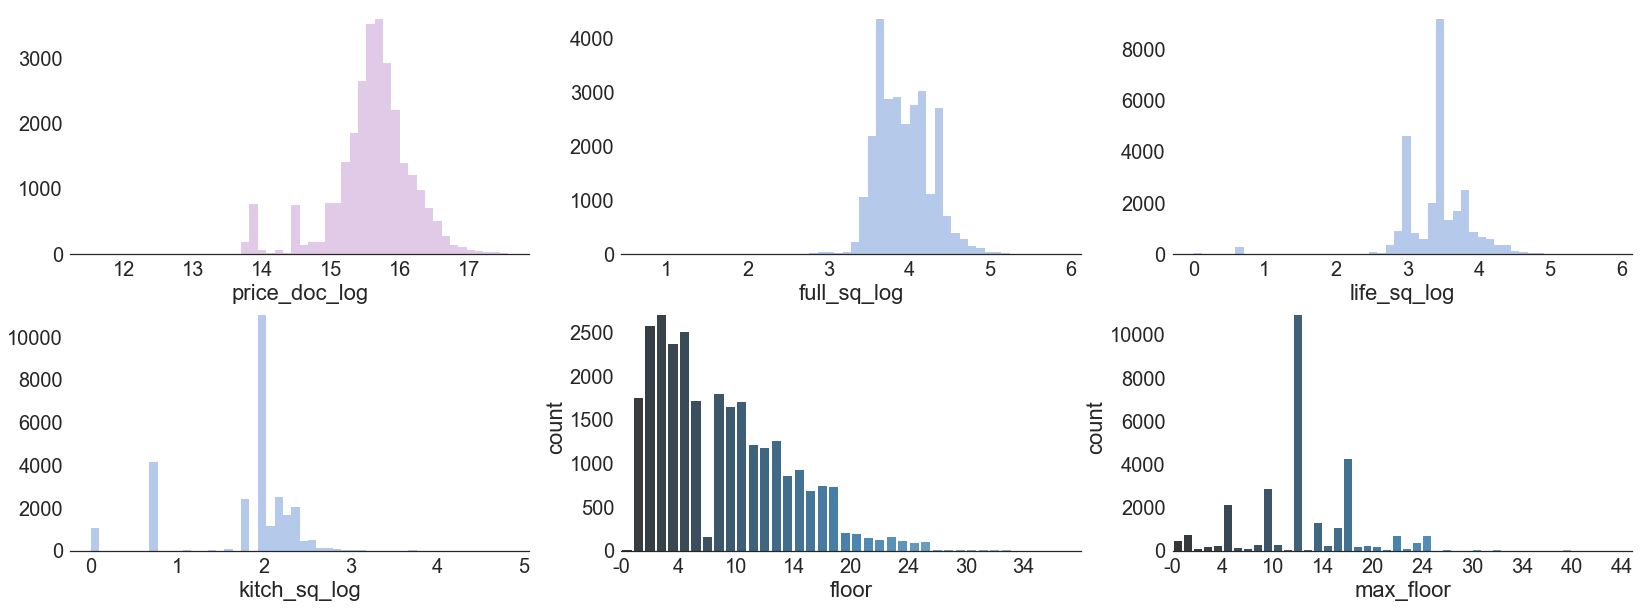

In [12]:
sns.set(style="white", palette="muted", color_codes=True, font_scale=2)

f, axes = plt.subplots(2, 3, figsize=(28, 10), sharex=False)
sns.despine(left=True)

sns.distplot(data_dwelling['price_doc_log'], color="m", ax=axes[0, 0], kde=False, hist=True)
sns.distplot(data_dwelling['full_sq_log'], color="b", ax=axes[0, 1], kde=False, hist=True)
sns.distplot(data_dwelling['life_sq_log'].dropna(), color="b", ax=axes[0, 2], kde=False, hist=True)
sns.distplot(data_dwelling['kitch_sq_log'].dropna(), color="b", ax=axes[1, 0], kde=False, hist=True)

plt_floor = sns.countplot(x=data_dwelling['floor'],ax=axes[1,1], palette='Blues_d')
start, end = plt_floor.get_xlim()
plt_floor.xaxis.set_ticks(np.arange(start, end, 5))
plt_floor.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.f'))

plt_maxfloor = sns.countplot(x=data_dwelling['max_floor'],ax=axes[1,2], palette='Blues_d')
start, end = plt_maxfloor.get_xlim()
plt_maxfloor.xaxis.set_ticks(np.arange(start, end, 5))
plt_maxfloor.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.f'))

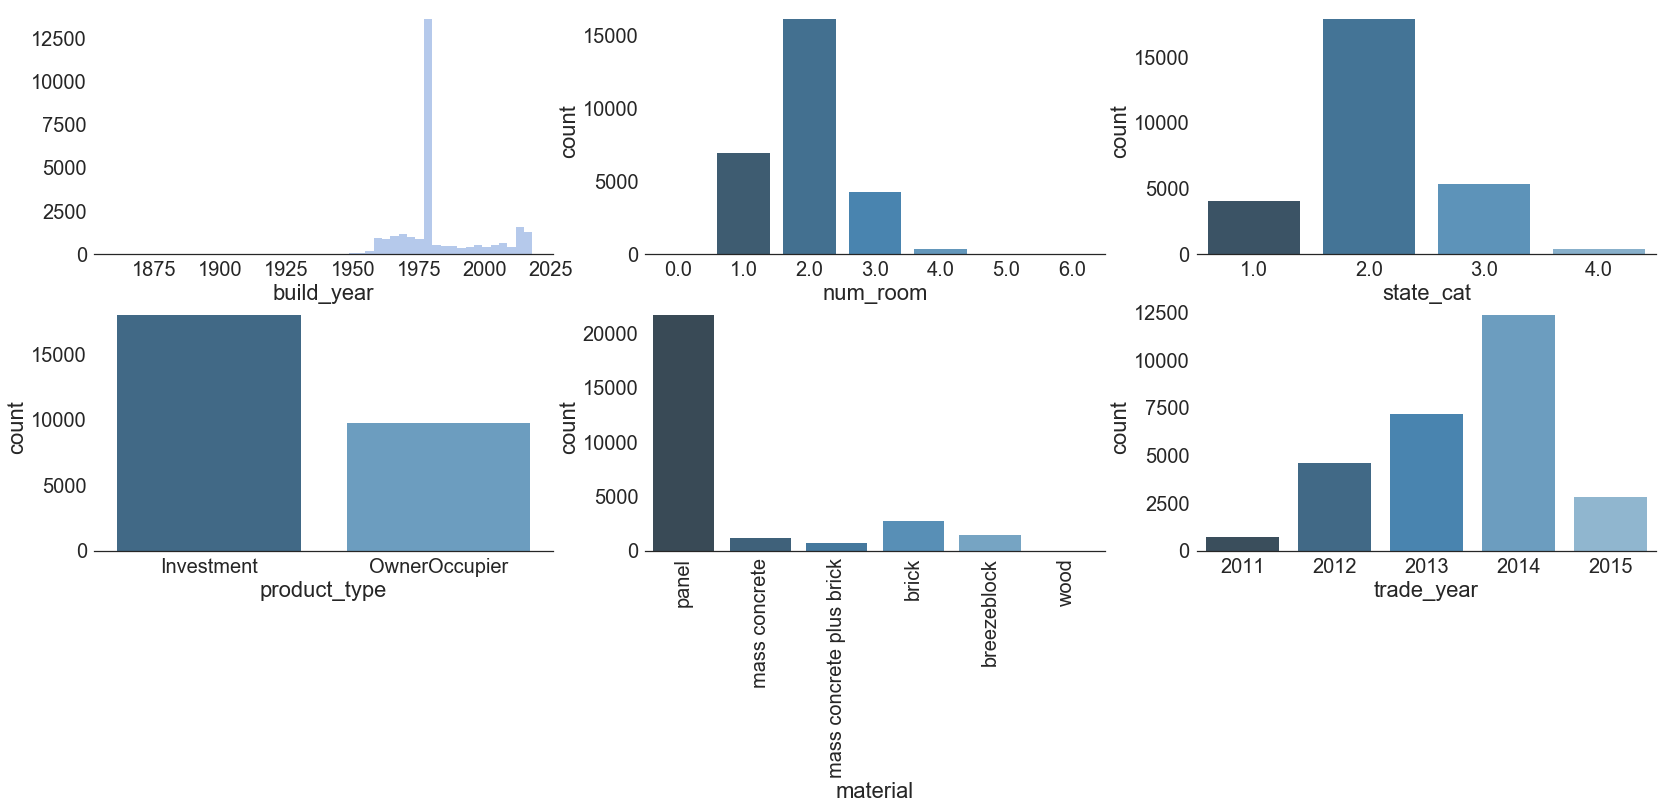

In [13]:
sns.set(style="white", palette="muted", color_codes=True, font_scale=2)

f, axes = plt.subplots(2, 3, figsize=(28, 10), sharex=False)
sns.despine(left=True)

sns.distplot(data_dwelling['build_year'].dropna(), color="b", ax=axes[0, 0], kde=False, hist=True)
sns.countplot(x=data_dwelling['num_room'].dropna(),ax=axes[0, 1], palette='Blues_d')
sns.countplot(x=data_dwelling['state_cat'].dropna(),ax=axes[0, 2], palette='Blues_d')
sns.countplot(x=data_dwelling['product_type'].dropna(),ax=axes[1, 0], palette='Blues_d')
plt_material = sns.countplot(x=data_dwelling['material'].dropna(),ax=axes[1, 1], palette='Blues_d')
plt.setp(plt_material.xaxis.get_majorticklabels(), rotation=90 )

sns.countplot(x=data_dwelling['trade_year'].dropna(),ax=axes[1, 2], palette='Blues_d')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5]),
 <a list of 9 Text xticklabel objects>)

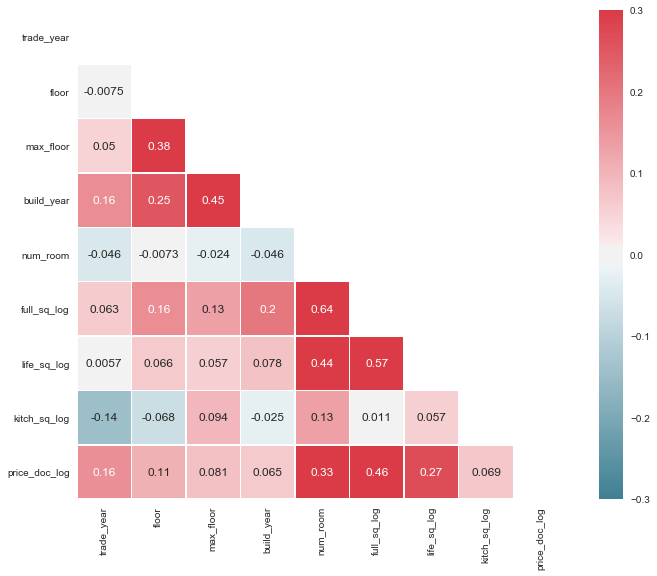

In [14]:
sns.set(style="white", palette="muted", color_codes=True, font_scale=1)

corr = data_dwelling.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=False, xticklabels=True, yticklabels=True,
            linewidths=.5, ax=ax, annot=True)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

(1800, 2136.2361180615803)

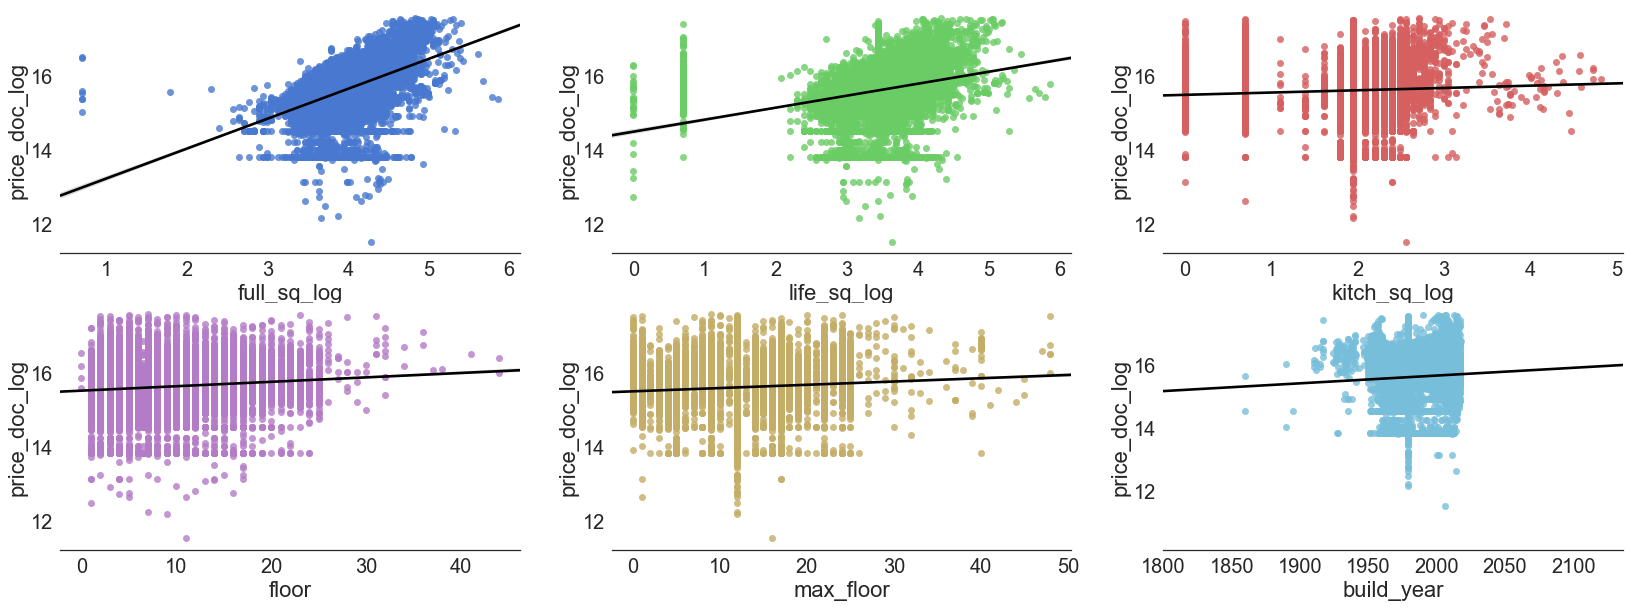

In [15]:
sns.set(style="white", palette="muted", color_codes=True, font_scale=2)

f, axes = plt.subplots(2, 3, figsize=(28, 10), sharex=False)
sns.despine(left=True)

g = sns.regplot(x = data_dwelling['full_sq_log'], y = data_dwelling['price_doc_log'], ax=axes[0, 0], line_kws={'color': 'black'})
g = sns.regplot(x = data_dwelling['life_sq_log'], y = data_dwelling['price_doc_log'], ax=axes[0, 1], line_kws={'color': 'black'})
g = sns.regplot(x = data_dwelling['kitch_sq_log'], y = data_dwelling['price_doc_log'], ax=axes[0, 2], line_kws={'color': 'black'})
g = sns.regplot(x = data_dwelling['floor'], y = data_dwelling['price_doc_log'], ax=axes[1, 0], line_kws={'color': 'black'})
g = sns.regplot(x = data_dwelling['max_floor'], y = data_dwelling['price_doc_log'], ax=axes[1, 1], line_kws={'color': 'black'})
g = sns.regplot(x = data_dwelling['build_year'].dropna(), y = data_dwelling['price_doc_log'], ax=axes[1, 2], line_kws={'color': 'black'}, ci=None)
axes[1,2].set_xlim(1800,)

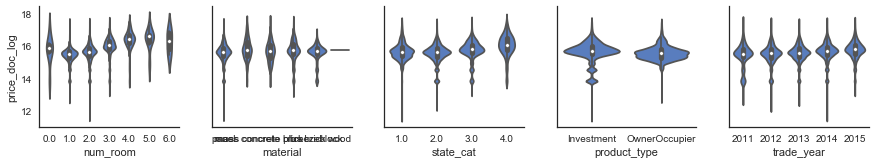

In [16]:
sns.set(style="white", palette="muted", color_codes=True, font_scale=1)

g = sns.PairGrid(data_dwelling, diag_sharey=False,
                 x_vars=['num_room', 'material', 'state_cat', 'product_type', 'trade_year'],
                  y_vars=['price_doc_log']
                )
g.map(sns.violinplot, color='b', jitter=True)

In [17]:
def rmsle(y_true, y_pred):
    ''' Function for calculatig RMSLE from predicted and true y'''
    assert len(y_true) == len(y_pred)
    terms_to_sum = [(np.log(y_pred[i] + 1) - np.log(y_true[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y_true))) ** 0.5

In [18]:
def train_model(model, param_dict, X, y, score_function, RFE_step = 1):
    '''
    Cross validates pipeline object with RFE
    '''
    # Train model
    selector=RFE(model,step=RFE_step)
    pipe_model= Pipeline(steps=[('RFE', selector), ('model', model)])
    gs = GridSearchCV(pipe_model, param_dict, scoring=make_scorer(score_function), cv=5, verbose=1)
    gs.fit(X.values, y.values)
    
    return gs.best_estimator_

In [19]:
def plot_features(best_model, features_all, plot_number):
    '''Plots importances of chosen features'''
    sns.set(style="white", palette="muted", color_codes=True, font_scale=1)
    features_best = best_model.named_steps['RFE'].get_support()
    features_chosen=[]
    for feature_name, feature_boo in zip(features_all, features_best):
        if feature_boo:
            features_chosen.append(feature_name)
    f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
    importances = best_model.named_steps['model'].feature_importances_
    indices = np.argsort(importances)[-plot_number:][::-1]
    
    display("All features: {}".format(len(features_all)))
    display("Length of best features: {}".format(len(features_best)))
    display("Chosen number of best features: {}".format(np.sum(features_best)))
    display("Chosen features: {}".format(len(features_chosen)))
    display("Number of best indices: {}".format(len(indices)))
    display("Number of best importances: {}".format(len(importances)))

    x = np.array([features_chosen[i] for i in indices])
    y = np.array([importances[i] for i in indices])
    sns.barplot(x, y, palette="Blues_d", ax=ax1)
    ax1.set_ylabel("Feature importance")
    plt.xticks(rotation=90) 
    
    return [features_chosen[i] for i in indices]

In [21]:
def test_model(best_model, features, score_function, X):
    '''Tests a models performance on test dataset'''
    y_pred = best_model.predict(X[features])
    y_pred_exp = np.exp(y_pred)
    y_test_exp = np.exp(y_test.values)
    test_score = score_function(y_test_exp, y_pred_exp)
    
    return test_score, y_pred

In [52]:
# Constructing DataFrame for Machine Learning Models

vars_dwelling=[  'floor',
                 'max_floor',
                 'material',
                 'build_year',
                 'num_room',
                 'state_cat',
                 'product_type',
                 'full_sq_log',
                 'life_sq_log',
                 'kitch_sq_log']

y_var = ['price_doc_log']

# Load in area specific variables
area_vars_list = pd.read_csv('area_vars.csv')['area_vars'].tolist()
vars_area=[]
for var in area_vars_list:
    if var in data:
        vars_area.append(var)

# Load in macro economic variables
macro_vars_list = pd.read_csv('macro_vars.csv')['macro_vars'].tolist()        
vars_macro=[]
for var in macro_vars_list:
    if var in data:
        vars_macro.append(var)       

# Set up dataframe
vars_all = y_var + vars_dwelling + vars_area + vars_macro
df_all = pd.get_dummies(data[vars_all].copy(deep=True))
df_y = df_all['price_doc_log']
df_x = df_all.drop('price_doc_log', axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.25, random_state=seed)

# Get headers (could also use label encoding)
area_headers = pd.get_dummies(data[vars_area]).columns.values
macro_headers = pd.get_dummies(data[vars_macro]).columns.values
dwelling_headers = pd.get_dummies(data[vars_dwelling]).columns.values
naive_headers = np.concatenate((dwelling_headers, macro_headers, area_headers), axis=0)

In [38]:
# Calculate a "Best Guess Benchmark"

def guess_rmsle(y_pred, y_test, score_function):
    y_guess_exp = np.exp(y_pred) * np.ones(y_test.shape)
    y_test_exp = np.exp(y_test.values)
    test_score = score_function(y_test_exp, y_guess_exp)
    return test_score
    
y_guess=data["price_doc_log"].mean()
display(y_guess)
rmsle_guess = guess_rmsle(y_guess, y_test, rmsle)
display("The test RMSLE for the guess is: {}".format(rmsle_guess))

15.598788164107761

'The test RMSLE for the guess is: 0.59666602645'

In [39]:
# Build or load dwelling model
if build_dwelling:
    gbm_dwelling=GradientBoostingRegressor(random_state=seed, verbose=0)
#     params_gbm_dwelling = {"RFE__n_features_to_select": [int(math.ceil(0.1*len(dwelling_headers))),
#                                                          int(math.ceil(0.3*len(dwelling_headers))), 
#                                                          int(math.ceil(0.5*len(dwelling_headers))), 
#                                                          int(len(dwelling_headers))],
    params_gbm_dwelling = {"RFE__n_features_to_select": [int(math.ceil(0.1*len(dwelling_headers)))],

                           "model__learning_rate" : [0.1],
                           "model__n_estimators" : [100]}
    
    best_dwelling_model = train_model(gbm_dwelling, params_gbm_dwelling, X_train[dwelling_headers], y_train, rmsle, RFE_step = 1)
    pickle.dump(best_dwelling_model, open(dwelling_model, 'wb'))
else:
    best_dwelling_model = loaded_dwelling_model
display(best_dwelling_model)

Pipeline(steps=[('RFE', RFE(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
        ...         presort='auto', random_state=13, subsample=1.0, verbose=0,
             warm_start=False))])

'All features: 19'

'Length of best features: 19'

'Chosen number of best features: 2'

'Chosen features: 2'

'Number of best indices: 2'

'Number of best importances: 2'

'The test RMSLE for the dwelling model is: 0.515531330209'

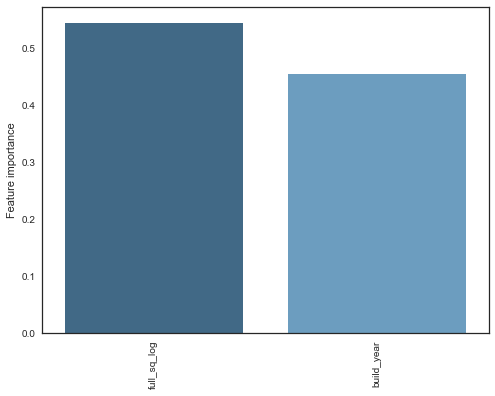

In [42]:
# Plot feature importances and test model on test set
features_chosen_dwelling = plot_features(best_dwelling_model, dwelling_headers, 4)
rmsle_dwelling, y_dwelling = test_model(best_dwelling_model, dwelling_headers, rmsle, X_test[dwelling_headers])
display("The test RMSLE for the dwelling model is: {}".format(rmsle_dwelling))

In [43]:
# Build or load area model
if build_area:
    gbm_area=GradientBoostingRegressor(random_state=seed, verbose=0)
#     params_gbm_area = {"RFE__n_features_to_select": [int(math.ceil(0.1*len(area_headers))), 
#                                                      int(math.ceil(0.3*len(area_headers))), 
#                                                      int(math.ceil(0.5*len(area_headers)))],
    params_gbm_area = {"RFE__n_features_to_select": [int(math.ceil(0.3*len(area_headers)))],
                       "model__learning_rate" : [0.1],
#                        "model__learning_rate" : [0.01, 0.05, 0.1, 0.5, 1.0],
                       "model__n_estimators" : [100]
                    }

    best_area_model = train_model(gbm_area, params_gbm_area, X_train[area_headers], y_train, rmsle, RFE_step = 50)
    pickle.dump(best_area_model, open(area_model, 'wb'))
else:
    best_area_model = loaded_area_model
display(best_area_model)

Pipeline(steps=[('RFE', RFE(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
        ...         presort='auto', random_state=13, subsample=1.0, verbose=0,
             warm_start=False))])

'All features: 303'

'Length of best features: 325'

'Chosen number of best features: 91'

'Chosen features: 91'

'Number of best indices: 40'

'Number of best importances: 91'

'The test RMSLE for only the area model is: 0.549120901035'

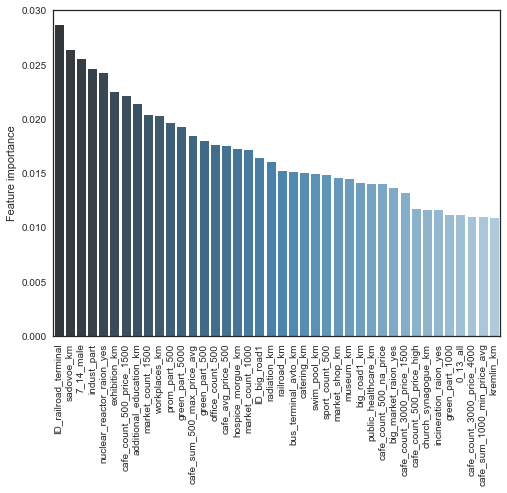

In [44]:
# Plot feature importances and test model on test set
features_chosen_area = plot_features(best_area_model, area_headers, 40)
rmsle_area, y_area = test_model(best_area_model, area_headers, rmsle, X_test)
display("The test RMSLE for only the area model is: {}".format(rmsle_area))
# X_train['area_score'] = best_area_model.predict(X_train[area_headers])
# display(pd.DataFrame(features_chosen_area))

In [45]:
# Build or load macro model
if build_macro:
    params_gbm_macro = {"RFE__n_features_to_select": [int(math.ceil(0.1*len(macro_headers))), 
                                                      int(math.ceil(0.3*len(macro_headers))), 
                                                      int(math.ceil(0.5*len(macro_headers)))],
#     params_gbm_macro = {"RFE__n_features_to_select": [int(math.ceil(0.3*len(macro_headers)))],
                        "model__learning_rate" : [0.1],
                        "model__n_estimators" : [100]
                       }

    best_macro_model = train_model(gbm_macro, params_gbm_macro, X_train[macro_headers], y_train, rmsle, RFE_step = 25)
    pickle.dump(best_macro_model, open(macro_model, 'wb'))
else:
    best_macro_model = loaded_macro_model
display(best_macro_model)

Pipeline(steps=[('RFE', RFE(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
        ...         presort='auto', random_state=13, subsample=1.0, verbose=0,
             warm_start=False))])

'All features: 106'

'Length of best features: 108'

'Chosen number of best features: 32'

'Chosen features: 32'

'Number of best indices: 32'

'Number of best importances: 32'

'The test RMSLE for only the macro model is: 0.59058037719'

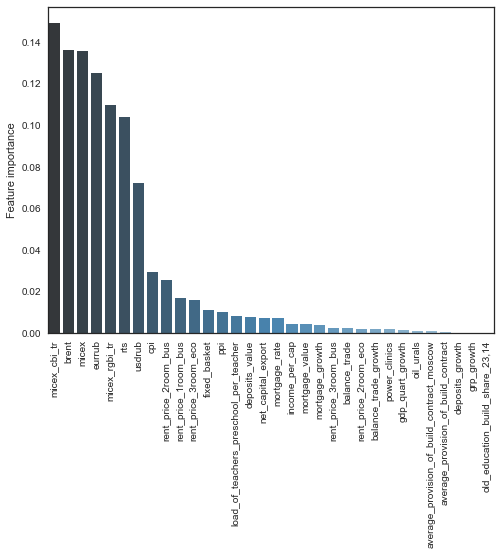

In [46]:
# Plot feature importances and test model on test set
features_chosen_macro = plot_features(best_macro_model, macro_headers,32)
rmsle_macro, y_macro = test_model(best_macro_model, macro_headers, rmsle, X_test)
display("The test RMSLE for only the macro model is: {}".format(rmsle_macro))
# X_train['macro_score'] = best_macro_model.predict(X_train[macro_headers])

In [53]:
# Build or load Random Forest Benchmark model
if True:
    rf = RandomForestRegressor(n_estimators=50)
    rf.fit(X_train[naive_headers], y_train)
    pickle.dump(rf, open(rf_model, 'wb'))
else:
    display("Loading model.")
    rf = loaded_rf_model
display(rf)
display("Fitted features: {}".format(len(naive_headers)))
display("Model input features: {}".format(rf.n_features_))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

'Fitted features: 428'

'Model input features: 452'

In [54]:
# Test RF benchmark model
def test_rf(rf, X_test, y_test):
    y_pred = rf.predict(X_test)
    y_pred_exp = np.exp(y_pred)
    y_test_exp = np.exp(y_test.values)
    test_score = rmsle(y_test_exp, y_pred_exp)
    display("The test RMSLE for the Random Forrest model is: {}".format(test_score))
    return test_score

rmsle_rf = test_rf(rf, X_test[naive_headers], y_test)

'The test RMSLE for the Random Forrest model is: 0.487276346624'

'All features: 428'

'Number of best indices: 25'

'Number of best importances: 452'

array([ 0.23770385,  0.02816554,  0.02653512,  0.01617092,  0.00900093,
        0.00805907,  0.00787892,  0.00748942,  0.00726684,  0.00702456,
        0.00694129,  0.0068773 ,  0.00683266,  0.0065255 ,  0.00649632,
        0.00642457,  0.0063836 ,  0.00634418,  0.00614779,  0.00608353,
        0.00599038,  0.00592846,  0.0058826 ,  0.0058645 ,  0.00579119])

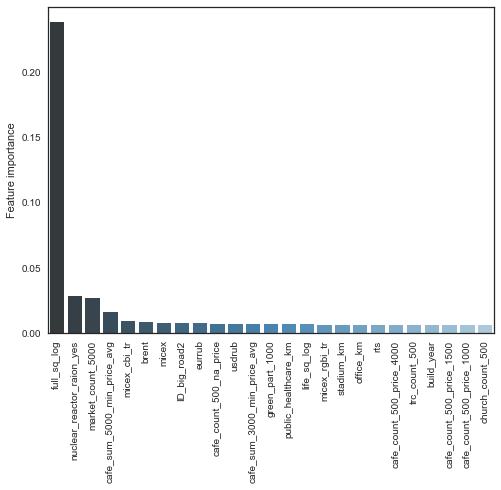

In [56]:
def plot_rf_importances(rf_model, features):
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[-25:][::-1]
    
    display("All features: {}".format(len(features)))
    display("Number of best indices: {}".format(len(indices)))
    display("Number of best importances: {}".format(len(importances)))
    
    x = np.array([features[i] for i in indices])
    y = np.array([importances[i] for i in indices])
    display(y)
    f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
    sns.barplot(x, y, palette="Blues_d", ax=ax1)
    ax1.set_ylabel("Feature importance")
    plt.xticks(rotation=90) 
    plt.show()

plot_rf_importances(rf, naive_headers)

In [57]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train[naive_headers].values, y_train.values)
dtest = xgb.DMatrix(X_test[naive_headers].values)

In [58]:
# Build or load XGB model
if build_xgb:
    cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
    cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
    num_boost_rounds = len(cv_output)
    best_xgb_model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)
    fig, ax = plt.subplots(1, 1, figsize=(8, 13))
    xgb.plot_importance(best_xgb_model, max_num_features=50, height=0.5, ax=ax)
    pickle.dump(best_xgb_model, open(xgb_model, 'wb'))
else:
    best_xgb_model = loaded_xgb_model

In [59]:
# Test XGB model
y_pred_xgb = best_xgb_model.predict(dtest)
y_pred_exp_xgb = np.exp(y_pred_xgb)
y_test_exp_xgb = np.exp(y_test.values)
rmsle_xgb = rmsle(y_test_exp_xgb, y_pred_exp_xgb)
display("The test RMSLE for the XGB model is: {}".format(rmsle_xgb))

'The test RMSLE for the XGB model is: 0.476827790545'

In [62]:
# Build or load naive model
if build_naive:
    gbm_naive=GradientBoostingRegressor(random_state=seed, verbose=0)
    params_gbm_naive = {"RFE__n_features_to_select": [int(math.ceil(1*len(naive_headers)))],
                        "model__learning_rate" : [0.05],
                        "model__n_estimators" : [100],
                        "model__max_depth" : [5]
                    }
    best_naive_model = train_model(gbm_naive, params_gbm_naive, X_train[naive_headers], y_train, rmsle, RFE_step = 25)
    naive_model = 'naive_model.sav'
    pickle.dump(best_naive_model, open(naive_model, 'wb'))
else:
    best_naive_model = loaded_naive_model
display(best_naive_model.named_steps['model'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=13, subsample=1.0, verbose=0,
             warm_start=False)

'All features: 428'

'Length of best features: 452'

'Chosen number of best features: 428'

'Chosen features: 405'

'Number of best indices: 25'

'Number of best importances: 428'

'The test RMSLE for the naive boosted model is: 0.477805808236'

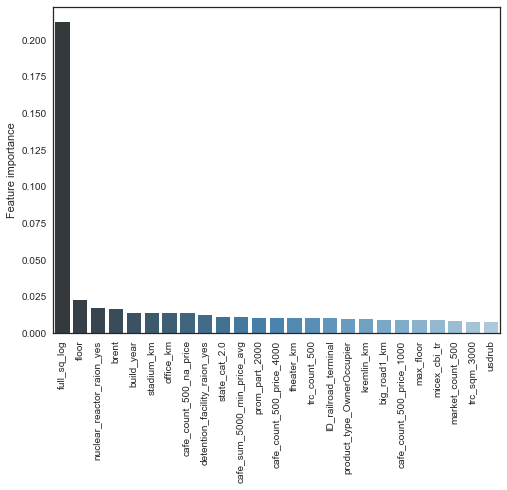

In [63]:
# Plot feature importances and test model on test set
features_chosen_naive = plot_features(best_naive_model, naive_headers, 25)
rmsle_naive, y_pred = test_model(best_naive_model, naive_headers, rmsle, X_test)
display("The test RMSLE for the naive boosted model is: {}".format(rmsle_naive))

'All features: 428'

'Length of best features: 452'

'Chosen number of best features: 428'

'Chosen features: 405'

'Number of best indices: 100'

'Number of best importances: 428'

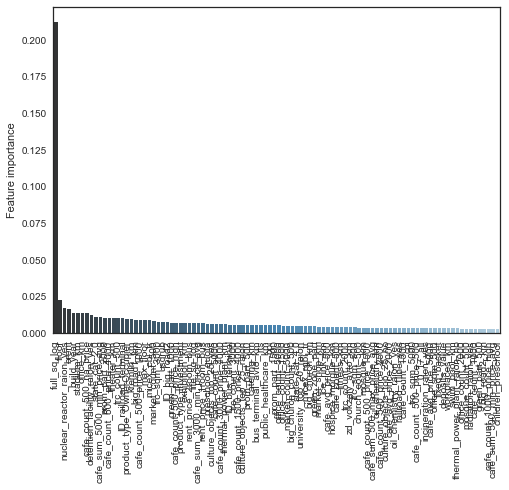

In [64]:
top100_headers = plot_features(best_naive_model, naive_headers, 100)
top25_headers =  top100_headers[:25]
top13_headers =  top100_headers[:13]

In [68]:
# Build or load improved model
if build_improved:
    improved_headers = top100_headers
    gbm_improved=GradientBoostingRegressor(random_state=seed, verbose=0)
    params_gbm_improved = {"RFE__n_features_to_select": [10, 25, 50, 100],
                        "model__learning_rate" : [0.05],
                        "model__max_depth" : [4, 5],
                        "model__n_estimators" : [100],
                        "model__subsample" : [0.8, 1.0],
                        "model__min_samples_split" : [2, 3]
                    }
    best_improved_model = train_model(gbm_improved, params_gbm_improved, X_train[improved_headers], y_train, rmsle, RFE_step = 25)
    pickle.dump(best_improved_model, open(improved_model, 'wb'))
else:
    best_improved_model = loaded_improved_model
display(best_improved_model.named_steps['model'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=3,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=13, subsample=0.8, verbose=0,
             warm_start=False)

'All features: 100'

'Length of best features: 101'

'Chosen number of best features: 10'

'Chosen features: 10'

'Number of best indices: 10'

'Number of best importances: 10'

'The test RMSLE for the improved boosted model is: 0.485397477119'

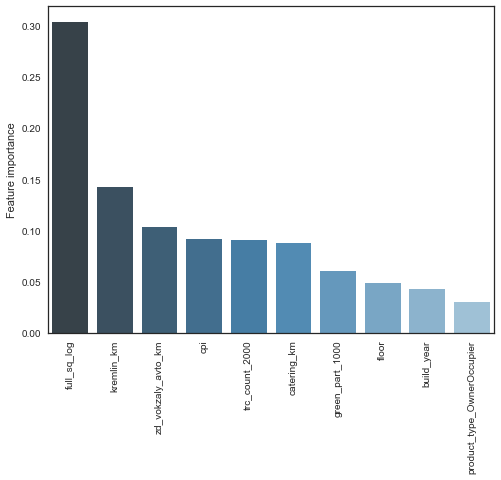

In [69]:
# Plot feature importances and test model on test set
features_chosen_improved = plot_features(best_improved_model, improved_headers, 10)
rmsle_improved, y_pred = test_model(best_improved_model, improved_headers, rmsle, X_test)
display("The test RMSLE for the improved boosted model is: {}".format(rmsle_improved))

In [76]:
if True:
    improved_headers_v02 = top100_headers
    gbm_improved_v02=GradientBoostingRegressor(random_state=seed, verbose=0)
    params_gbm_improved_v02 = {"RFE__n_features_to_select": [100],
                        "model__learning_rate" : [0.05],
                        "model__max_depth" : [4],
                        "model__n_estimators" : [100],
                        "model__subsample" : [0.8],
                        "model__min_samples_split" : [3]
                    }
    best_improved_v02_model = train_model(gbm_improved_v02, params_gbm_improved_v02, X_train[improved_headers_v02], y_train, rmsle, RFE_step =1)
    improved_v02_model = 'improved_model_v02.sav'
    pickle.dump(best_improved_v02_model, open(improved_v02_model, 'wb'))
else:
    best_improved_v02_model = loaded_improved_v02_model
display(best_improved_v02_model.named_steps['model'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=3,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=13, subsample=0.8, verbose=0,
             warm_start=False)

'All features: 100'

'Length of best features: 101'

'Chosen number of best features: 100'

'Chosen features: 99'

'Number of best indices: 50'

'Number of best importances: 100'

'The test RMSLE for the improved boosted model is: 0.48140762262'

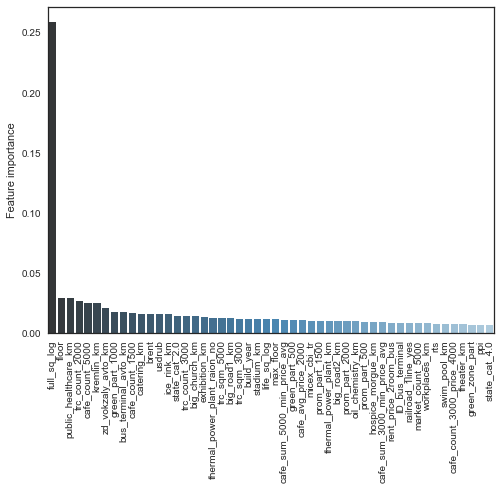

In [77]:
# Plot feature importances and test model on test set

features_chosen_improved_v02 = plot_features(best_improved_v02_model, top100_headers,50)
rmsle_improved_v02, y_pred = test_model(best_improved_v02_model, top100_headers, rmsle, X_test)
display("The test RMSLE for the improved boosted model is: {}".format(rmsle_improved_v02))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

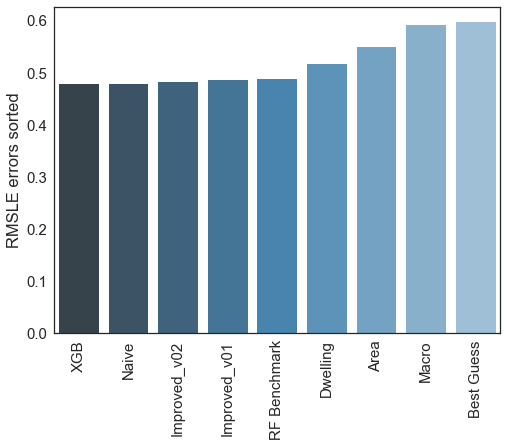

In [78]:
# Sum up results

sns.set(style="white", palette="muted", color_codes=True, font_scale=1.5)

errors = [rmsle_dwelling, 
          rmsle_area, 
          rmsle_macro, 
          rmsle_rf, 
          rmsle_naive,
          rmsle_guess,
          rmsle_improved,
          rmsle_improved_v02,
          rmsle_xgb
         ]

labels = ["Dwelling",
          "Area",
          "Macro",
          "RF Benchmark",
          "Naive",
          "Best Guess",
          "Improved_v01",
          "Improved_v02",
          "XGB"
          ]
f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
indices = np.argsort(errors)[::1]
x = np.array([labels[i] for i in indices])
y = np.array([errors[i] for i in indices])
sns.barplot(x, y, palette="Blues_d", ax=ax1)
ax1.set_ylabel("RMSLE errors sorted")
plt.xticks(rotation=90) 